In [1]:
%matplotlib inline
import pandas as pd
import os
import bidi.algorithm
import arabic_reshaper
import matplotlib.pyplot as plt

In [2]:
fpath = '/media/sf_VBox_Shared/Arabic/Analyses/Fiqh_final2/quotes'

In [4]:
links_df = pd.read_csv(os.path.join(fpath, 'fiqh_quran_links_v2.csv'))
nodes_aya_df = pd.read_csv(os.path.join(fpath, 'fiqh_quran_aya_nodes_v2.csv'))
nodes_books_df = pd.read_csv(os.path.join(fpath, 'fiqh_quran_book_nodes.csv'))
quotes_df = pd.read_csv(os.path.join(fpath, 'quran_quotes.csv'))

In [5]:
merged_df = links_df.merge(nodes_aya_df, left_on='Target', right_on='id')[['Source', 'Weight', 'sura_id', 'aya_id', 'sura_name', 'sura_arabic_name', 'Label']]
merged_df = merged_df.rename({'Label': 'aya_label'}, axis=1)
merged_df = merged_df.merge(nodes_books_df, left_on='Source', right_on='id')
merged_df = merged_df.drop(['Source', 'id', 'Type', 'Group', 'Label'], axis=1)

In [6]:
merged_df.to_csv(os.path.join(fpath, 'quotes_merged_v2.csv'), index=False)

In [7]:
def reshape_arabic(text):
    return bidi.algorithm.get_display(arabic_reshaper.reshape(text))

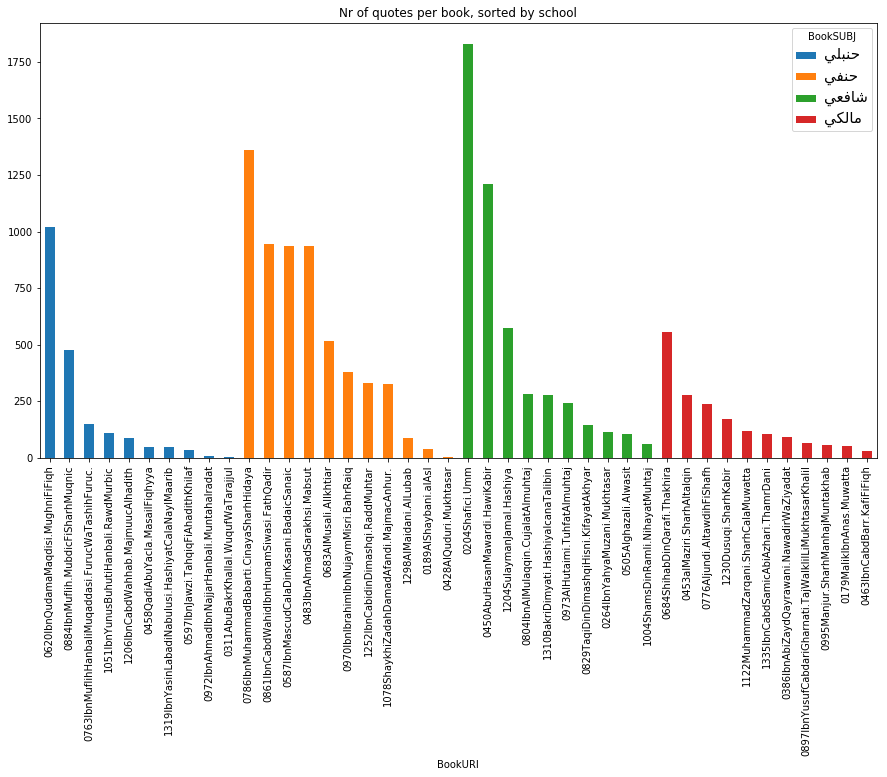

In [8]:
# Nr of quotes per book, sorted per school
count_per_book = merged_df.groupby(['BookURI', 'BookSUBJ'])['Weight'].sum().unstack()
barplot = count_per_book.sort_values(list(count_per_book.columns), ascending=False).plot(kind='bar', stacked=True, figsize=(15,8))
leg = barplot.axes.get_legend()
for t in leg.get_texts():
    t.set_text(reshape_arabic(t.get_text()))
    t.set_fontsize(15)
plt.title('Nr of quotes per book, sorted by school')
plt.show()

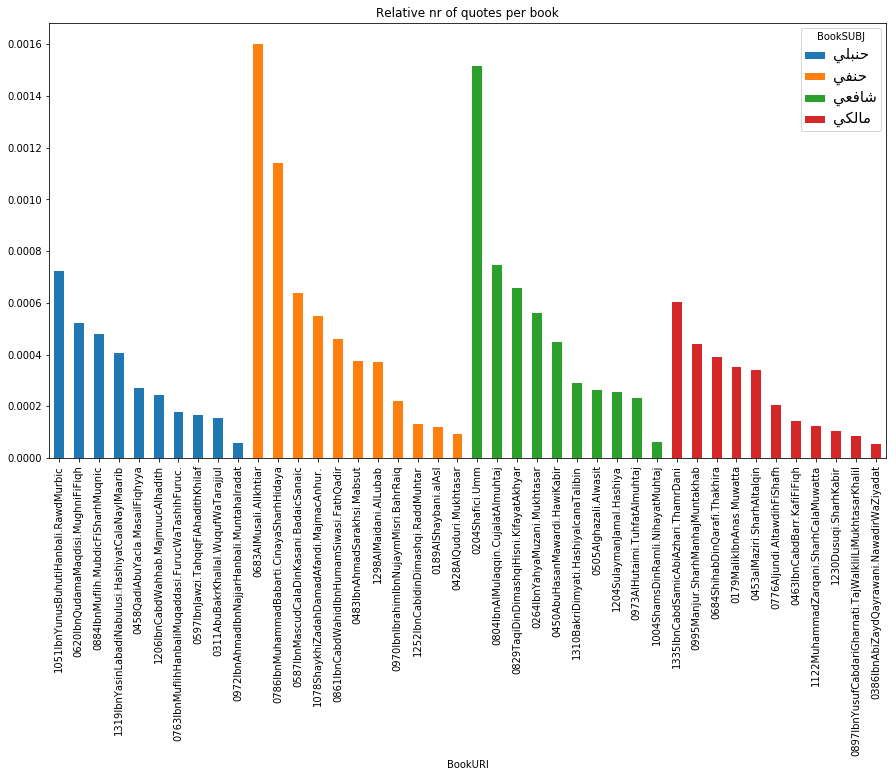

In [9]:
# Relative of quotes per book (divided by length of book) , sorted per school
nr_tokens_per_book = merged_df.groupby(['BookURI', 'BookSUBJ'])['Number_of_tokens'].min()
rel_count_per_book = merged_df.groupby(['BookURI', 'BookSUBJ'])['Weight'].sum() / nr_tokens_per_book
rel_count_per_book = rel_count_per_book.unstack()
barplot = rel_count_per_book.sort_values(list(rel_count_per_book.columns), ascending=False).plot(kind='bar', stacked=True, figsize=(15,8))
leg = barplot.axes.get_legend()
for t in leg.get_texts():
    t.set_text(reshape_arabic(t.get_text()))
    t.set_fontsize(15)
plt.title('Relative nr of quotes per book')
plt.show()

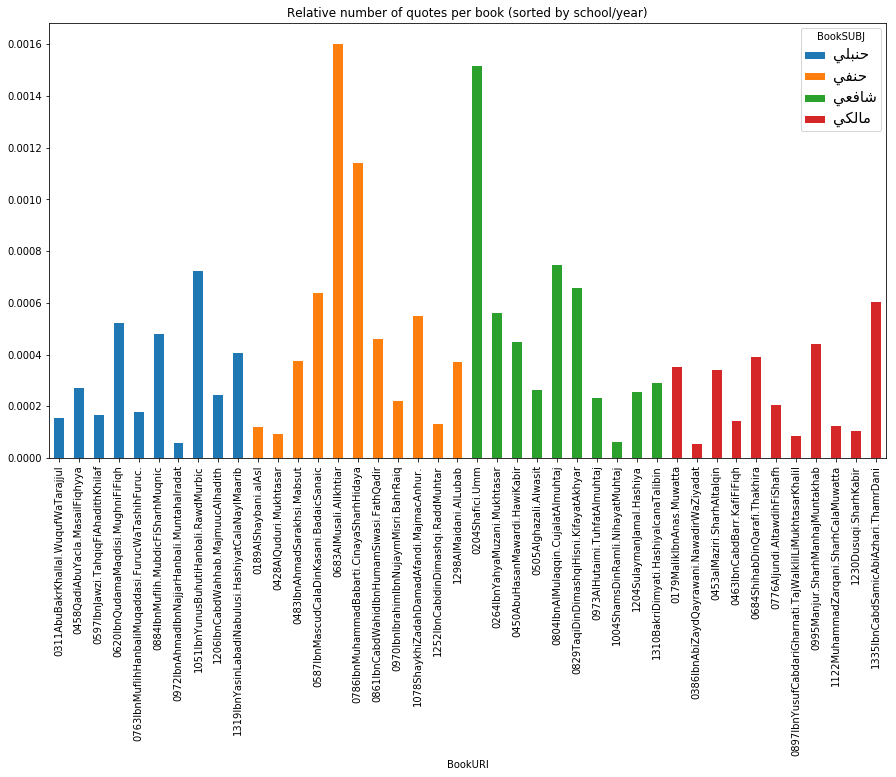

In [10]:
rel_count_per_book = merged_df.groupby(['BookURI', 'BookSUBJ'])['Weight'].sum() / nr_tokens_per_book
rel_count_per_book = rel_count_per_book.reset_index().sort_values(['BookSUBJ', 'BookURI'])
rel_count_per_book = rel_count_per_book.pivot('BookURI', 'BookSUBJ', 0).reindex(rel_count_per_book.BookURI)
barplot = rel_count_per_book.plot(kind='bar', stacked=True, figsize=(15,8))
leg = barplot.axes.get_legend()
for t in leg.get_texts():
    t.set_text(reshape_arabic(t.get_text()))
    t.set_fontsize(15)
plt.title('Relative number of quotes per book (sorted by school/year)')
plt.show()

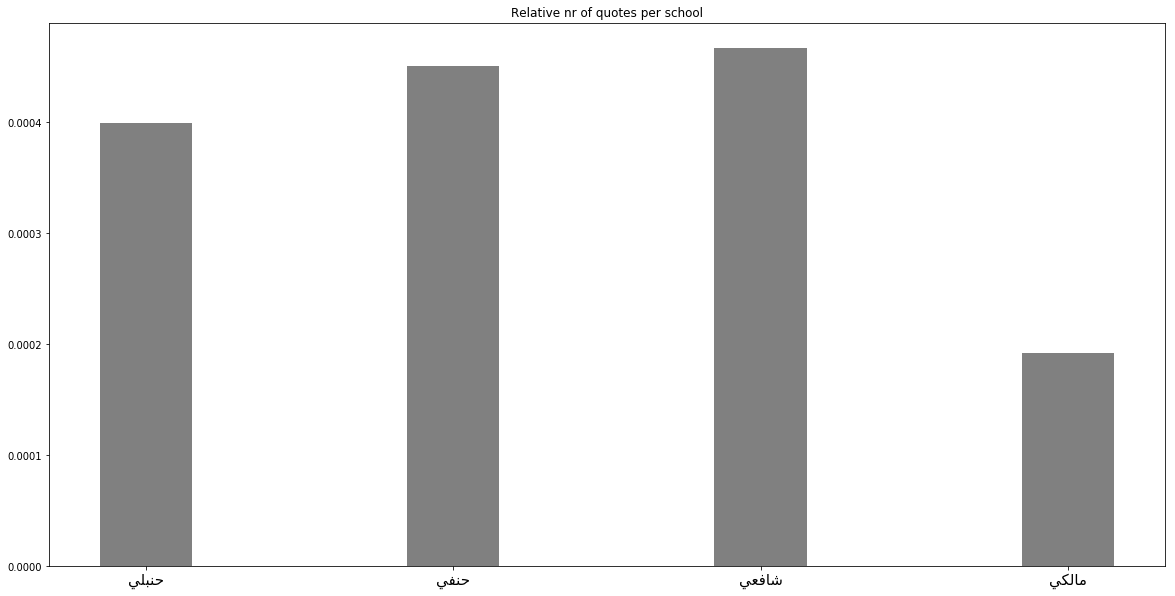

In [48]:
import matplotlib
rel_count_per_school = merged_df.groupby('BookSUBJ')['Weight'].sum() / nr_tokens_per_book.groupby('BookSUBJ').sum() 
#barplot = rel_count_per_school.plot(kind='bar', figsize=(20,10), colormap=)
plt.subplots(figsize=(20,10))
barplot = plt.bar(range(len(rel_count_per_school)), rel_count_per_school.values, color='grey', width=0.3)
#plt.x
plt.xticks(range(len(rel_count_per_school)), labels=[reshape_arabic(t) for t in rel_count_per_school.index], fontsize=15) #barplot.xaxis.get_ticklabels()])
#plt.xticks()
plt.title('Relative nr of quotes per school')
plt.show()

In [12]:
rel_count_per_school.to_csv(os.path.join(fpath, 'counts_pers_school.csv'))

In [13]:
import re
merged_df['Century_num'] = merged_df.Century.apply(lambda s: int(re.match('^[0-9]*', s).group(0)))

In [14]:
count_per_century_subj = merged_df.groupby(['Century_num', 'BookSUBJ'])['Weight'].sum()

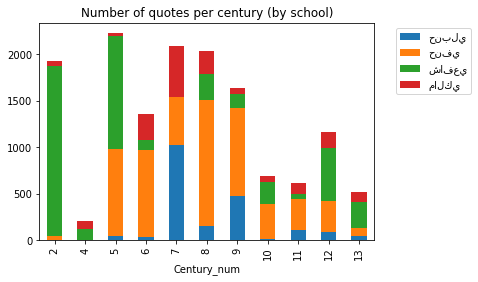

In [15]:
# Total number of quotes per century, per school
barplot = count_per_century_subj.unstack().plot(kind='bar', stacked=True)
leg = barplot.axes.get_legend()
for t in leg.get_texts():
    t.set_text(reshape_arabic(t.get_text()))
    t.set_fontsize(15)
plt.title('Number of quotes per century (by school)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [16]:
nrtokens_per_century_book = merged_df.groupby(['BookURI', 'Century_num'])['Number_of_tokens'].min()

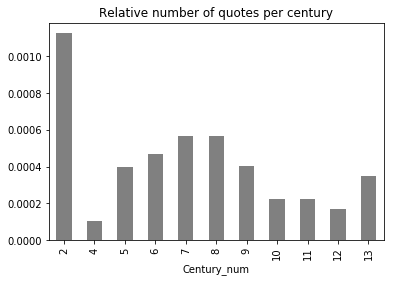

In [17]:
# Relative number of quotes per century
count_per_century = count_per_century_subj.groupby('Century_num').sum()
rel_count_per_century = count_per_century / nrtokens_per_century_book.groupby(['Century_num']).sum() 
barplot = rel_count_per_century.plot(kind='bar', color='grey')
plt.title('Relative number of quotes per century')
plt.show()

## Which verses are cited most often?
Which verses have the most citations in total? And by how many books are they cited?

In [18]:
counts_per_verse = pd.DataFrame({'nr_books': merged_df.aya_label.value_counts(), 
                                 'nr_citations': merged_df.groupby('aya_label')['Weight'].sum()})
counts_per_verse.sort_values('nr_citations', ascending=False).head(20)

,nr_books,nr_citations
Al-Baqarah 196,29,238
Al-Baqarah 282,28,228
An-Nisa' 43,32,201
An-Nisa' 11,28,192
Al-Ma'idah 95,29,190
An-Nisa' 23,28,160
Al-Baqarah 233,24,155
Al-Ma'idah 6,29,150
Al-Baqarah 228,27,137
At-Talaq 2,25,130


In [19]:
# What are the verses cited by most books?
print('What are the verses cited by most books?')
counts_per_verse.sort_values('nr_books', ascending=False).head(10)

What are the verses cited by most books?


,nr_books,nr_citations
An-Nisa' 43,32,201
Al-Baqarah 196,29,238
Al-Ma'idah 6,29,150
Al-Ma'idah 95,29,190
An-Nisa' 23,28,160
An-Nisa' 11,28,192
Al-Baqarah 282,28,228
Al-Baqarah 184,27,100
Al-Ikhlas 1,27,68
Al-Baqarah 228,27,137


## What are the most cited verses per school?
And by how many books are they cited?

In [20]:
from IPython.display import display
# What are the verses cited by most books, per school?
for school in merged_df.BookSUBJ.unique():
    print(school)
    df_sub = merged_df[merged_df.BookSUBJ==school]
    counts_per_verse_sub = pd.DataFrame({'nr_books': df_sub.aya_label.value_counts(), 
                                 'nr_citations': df_sub.groupby('aya_label')['Weight'].sum(),
                                        'books': df_sub.groupby('aya_label')['BookURI'].aggregate(set)})
    print('Total nr of books in this school: ', df_sub.BookURI.nunique())
    display(counts_per_verse_sub.sort_values('nr_citations', ascending=False).head(20))
    print('\n')

مالكي
Total nr of books in this school:  11


,nr_books,nr_citations,books
An-Naziat 20,1,51,{1122MuhammadZarqani.SharhCalaMuwatta}
An-Nisa' 11,7,33,"{0386IbnAbiZaydQayrawani.NawadirWaZiyadat, 077..."
An-Nisa' 43,7,31,{0897IbnYusufCabdariGharnati.TajWaIklilLiMukht...
Al-Baqarah 282,6,25,{0897IbnYusufCabdariGharnati.TajWaIklilLiMukht...
An-Nisa' 6,4,23,"{0684ShihabDinQarafi.Thakhira, 1230Dusuqi.Shar..."
Al-Ma'idah 6,5,20,"{0386IbnAbiZaydQayrawani.NawadirWaZiyadat, 077..."
An-Nisa' 23,5,20,"{1335IbnCabdSamicAbiAzhari.ThamrDani, 0776Alju..."
Al-Baqarah 196,5,19,"{0179MalikIbnAnas.Muwatta, 0776Aljundi.Altawdi..."
An-Nisa' 25,5,16,"{0386IbnAbiZaydQayrawani.NawadirWaZiyadat, 133..."
Al-Baqarah 237,5,16,"{0179MalikIbnAnas.Muwatta, 1335IbnCabdSamicAbi..."




شافعي
Total nr of books in this school:  10


,nr_books,nr_citations,books
Al-Baqarah 282,9,110,"{0804IbnAlMulaqqin.CujalatAlmuhtaj, 1310BakriD..."
Al-Ma'idah 95,9,79,"{0804IbnAlMulaqqin.CujalatAlmuhtaj, 1310BakriD..."
An-Nisa' 43,10,78,"{0804IbnAlMulaqqin.CujalatAlmuhtaj, 1310BakriD..."
Al-Baqarah 196,9,75,"{0804IbnAlMulaqqin.CujalatAlmuhtaj, 1310BakriD..."
At-Talaq 2,9,69,"{0804IbnAlMulaqqin.CujalatAlmuhtaj, 1310BakriD..."
Al-Baqarah 229,8,62,"{0804IbnAlMulaqqin.CujalatAlmuhtaj, 1310BakriD..."
Al-Baqarah 228,8,55,"{0804IbnAlMulaqqin.CujalatAlmuhtaj, 1310BakriD..."
Al-Mumtahina 10,6,54,"{0804IbnAlMulaqqin.CujalatAlmuhtaj, 0505Alghaz..."
Al-Baqarah 237,8,54,"{0804IbnAlMulaqqin.CujalatAlmuhtaj, 1310BakriD..."
An-Nisa' 11,8,52,"{0804IbnAlMulaqqin.CujalatAlmuhtaj, 1310BakriD..."




حنفي
Total nr of books in this school:  11


,nr_books,nr_citations,books
Al-Baqarah 196,10,112,"{0970IbnIbrahimIbnNujaymMisri.BahrRaiq, 1252Ib..."
Al-Baqarah 233,9,98,"{0970IbnIbrahimIbnNujaymMisri.BahrRaiq, 1252Ib..."
An-Nisa' 11,9,76,"{0970IbnIbrahimIbnNujaymMisri.BahrRaiq, 1252Ib..."
Al-Baqarah 282,9,71,"{0970IbnIbrahimIbnNujaymMisri.BahrRaiq, 1252Ib..."
An-Nisa' 23,9,71,"{0970IbnIbrahimIbnNujaymMisri.BahrRaiq, 1252Ib..."
Al-Ma'idah 95,9,67,"{0970IbnIbrahimIbnNujaymMisri.BahrRaiq, 1252Ib..."
An-Nisa' 24,8,66,"{0970IbnIbrahimIbnNujaymMisri.BahrRaiq, 1252Ib..."
An-Nisa' 43,9,65,"{0970IbnIbrahimIbnNujaymMisri.BahrRaiq, 1252Ib..."
At-Talaq 4,9,63,"{0970IbnIbrahimIbnNujaymMisri.BahrRaiq, 1252Ib..."
Al-Ma'idah 6,10,57,"{0970IbnIbrahimIbnNujaymMisri.BahrRaiq, 1252Ib..."




حنبلي
Total nr of books in this school:  10


,nr_books,nr_citations,books
Al-Baqarah 196,5,32,{0763IbnMuflihHanbaliMuqaddasi.FurucWaTashihFu...
An-Nisa' 11,4,31,"{1051IbnYunusBuhutiHanbali.RawdMurbic, 0884Ibn..."
Al-Ma'idah 95,6,30,{0763IbnMuflihHanbaliMuqaddasi.FurucWaTashihFu...
An-Nisa' 43,6,27,{0763IbnMuflihHanbaliMuqaddasi.FurucWaTashihFu...
Al-Ikhlas 1,7,24,"{0972IbnAhmadIbnNajjarHanbali.MuntahaIradat, 0..."
Al-Baqarah 184,5,24,{0763IbnMuflihHanbaliMuqaddasi.FurucWaTashihFu...
Al-Ma'idah 6,5,23,{0763IbnMuflihHanbaliMuqaddasi.FurucWaTashihFu...
Al-Baqarah 282,4,22,"{1051IbnYunusBuhutiHanbali.RawdMurbic, 0884Ibn..."
Al-Ma'idah 89,3,22,"{0458QadiAbuYacla.MasailFiqhyya, 0884IbnMuflih..."
Al-Baqarah 228,5,21,"{0620IbnQudamaMaqdisi.MughniFiFiqh, 0884IbnMuf..."


## NLP approaches

In [21]:
adj_df = merged_df.pivot('BookURI', 'aya_label', 'Weight').fillna(0)

In [22]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(adj_df.values)
print(tfidf.shape)

(42, 2110)


In [23]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(tfidf, tfidf)
similarities.shape

(42, 42)

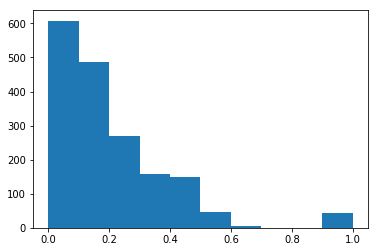

In [24]:
plt.hist(similarities.flatten());

In [25]:
import numpy as np
similarities_df = pd.DataFrame(similarities, columns=adj_df.index, index=adj_df.index)
np.fill_diagonal(similarities_df.values, 0)

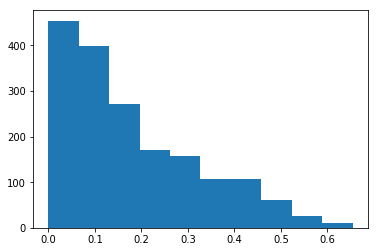

In [26]:
plt.hist(similarities_df.values.flatten());

In [27]:
from sklearn.metrics.pairwise import cosine_distances

from sklearn.manifold import TSNE

dist = cosine_distances(tfidf, tfidf)

X_embedded = TSNE(n_components=2, metric='precomputed').fit_transform(dist)
print(X_embedded.shape)

(42, 2)


In [28]:
df_books_embedded = pd.DataFrame(X_embedded, index=adj_df.index, columns=['x', 'y'])

In [29]:
df_books_embedded.head()

,x,y
BookURI,,
0179MalikIbnAnas.Muwatta,28.891611,-38.216454
0189AlShaybani.alAsl,-17.293917,-39.392632
0204Shafici.Umm,11.081448,17.422401
0264IbnYahyaMuzani.Mukhtasar,24.689215,19.406073
0311AbuBakrKhallal.WuqufWaTarajjul,55.250076,27.948505


In [30]:
df_books_embedded = df_books_embedded.merge(nodes_books_df, right_on='BookURI', left_on='BookURI')

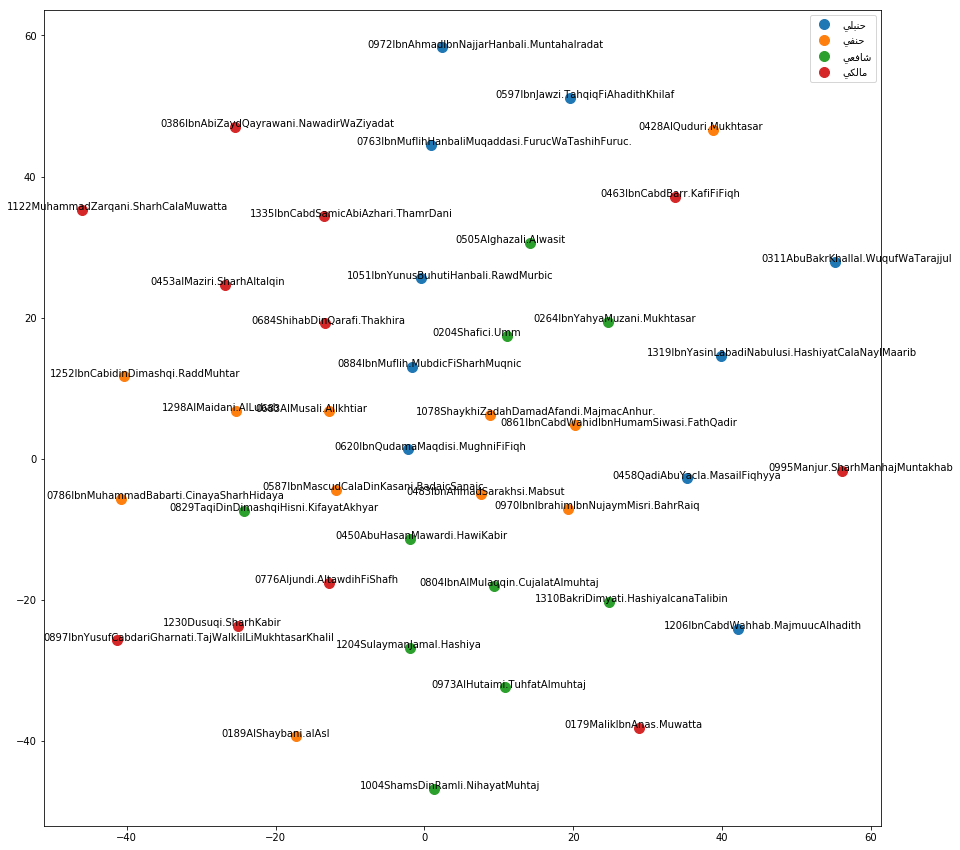

In [31]:
fig, ax = plt.subplots(figsize=(15,15))
for subj, group in df_books_embedded.groupby('BookSUBJ'):
    ax.plot(group.x, group.y, label=reshape_arabic(subj), marker='o', linestyle='', markersize=10)
    for x,y,s in zip(group.x, group.y, group.BookURI):
        ax.text(x-10, y, s)
ax.legend()
plt.show()

## Network analysis

In [32]:
import networkx as nx

In [33]:
# nw_similarities = nx.from_pandas_adjacency(similarities_df)
# list(nw_similarities.edges(data=True))[:10]

In [34]:
# nx.to_pandas_edgelist(nw_similarities).to_csv(os.path.join(fpath, 'links_tfidf_books.csv'), index=False)

In [35]:
links_df['Distance'] = 1.0/links_df.Weight
network = nx.from_pandas_edgelist(links_df, source='Source', target='Target', edge_attr=['Weight', 'Distance'])

In [36]:
nx.algorithms.is_bipartite(network)

True

In [37]:
book_ids = links_df.Source.unique()
verse_ids = links_df.Target.unique()

In [38]:
network_books = nx.bipartite.weighted_projected_graph(network, book_ids)
network_verses = nx.bipartite.weighted_projected_graph(network, verse_ids)

In [39]:
print(network.number_of_edges(), network.number_of_nodes())
print(network_books.number_of_edges(), network_books.number_of_nodes())
print(network_verses.number_of_edges(), network_verses.number_of_nodes())

7458 2152
824 42
731100 2110


In [40]:
weights = nx.get_edge_attributes(network_books, 'weight')
nx.set_edge_attributes(network_books, 
                      {k: 1/weights[k] for k in weights},
                      'distance')

In [41]:
closeness_centrality_books = nx.closeness_centrality(network_books, distance='distance')
#closeness_centrality_verses = nx.closeness_centrality(network_verses)

In [42]:
betweenness_centrality_books = nx.betweenness_centrality(network_books, weight='distance')
#betweenness_centrality_verses = nx.betweenness_centrality(network_verses)

In [43]:
nodes_books_df = nodes_books_df.set_index('id')
nodes_books_df['closeness_centrality'] = pd.Series(closeness_centrality_books)
nodes_books_df['betweenness_centrality'] = pd.Series(betweenness_centrality_books)
nodes_books_df = nodes_books_df.reset_index()

In [ ]:
nodes_aya_df = nodes_aya_df.set_index('id')
#nodes_aya_df['closeness_centrality'] = pd.Series(closeness_centrality_verses)
nodes_aya_df['betweenness_centrality'] = pd.Series(betweenness_centrality_verses)
nodes_aya_df = nodes_aya_df.reset_index()

In [ ]:
nodes_aya_df.head()

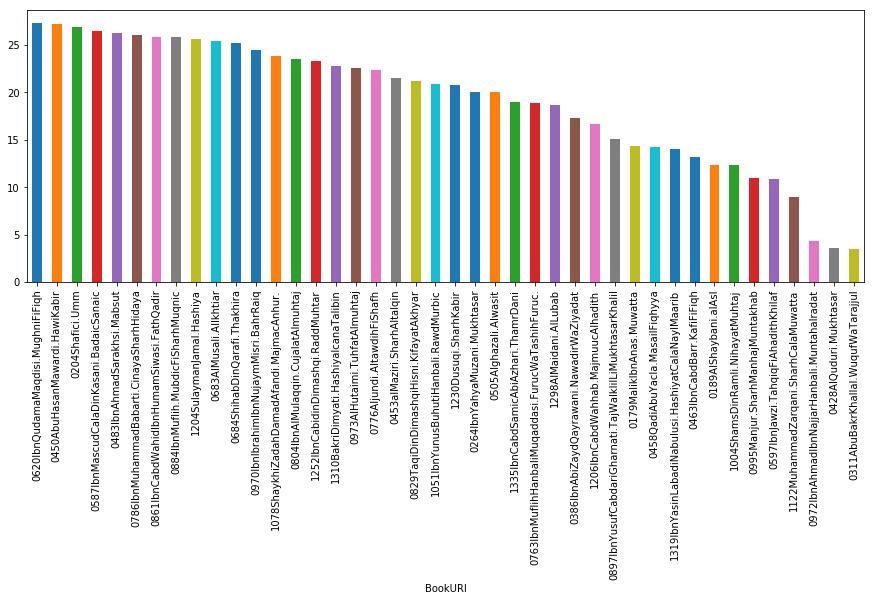

In [45]:
book_closeness = nodes_books_df.set_index('BookURI')['closeness_centrality']

book_closeness.sort_values(ascending=False).plot(kind='bar', figsize=(15,5))

In [ ]:
book_closeness.sort_values(ascending=False)

In [ ]:
book_betweenness = nodes_books_df.set_index('BookURI')['betweenness_centrality']

book_betweenness.sort_values(ascending=False).plot(kind='bar', figsize=(15,5))

In [ ]:
book_betweenness.sort_values(ascending=False)

In [ ]:
verse_closeness = nodes_aya_df.set_index('Label')['closeness_centrality']

verse_closeness.sort_values(ascending=False).head(30).plot(kind='bar', figsize=(15,5))

In [ ]:
# Get projected graphs
book_ids = links_df.Source.unique()
nw_books_jaccard = nx.algorithms.bipartite.overlap_weighted_projected_graph(network, book_ids)
nw_books_overlap

In [ ]:
list(nw_books.edges(data=True))[:10]

In [ ]:
nx.to_pandas_edgelist(nw_books).to_csv(os.path.join(fpath, 'links_projected_books.csv'), index=False)